# Judul Topik : Deteksi Kebakaran Menggunakan Model Deep Learning dan Ekstraksi Fitur Bottleneck Xception

Nama        : Feby Akliji Rofiah

NIM         : A11.2022.14529

Kelas       : A11.4419

Matkul      : Pembelajaran Mesin

## 1. Ringkasan dan Permasalahan

## Ringkasan

Project ini membahas tentang pengembangan model deteksi kebakaran menggunakan teknik deep learning, memanfaatkan ekstraksi fitur bottleneck dari model Xception. Prosesnya meliputi analisis data, pemrosesan gambar, pelatihan model, pengujian, serta evaluasi hasil dan fitur dari model deteksi kebakaran yang dikembangkan. Penelitian ini bertujuan untuk menciptakan sistem deteksi kebakaran yang andal dan cepat untuk meningkatkan respon terhadap kejadian kebakaran.

## Permasalahan
Kebakaran menimbulkan kerugian besar baik materi maupun nyawa. Metode tradisional yang mengandalkan pengawasan manual sering kali tidak efisien dan tidak memberikan peringatan dini yang cepat. Oleh karena itu, diperlukan sistem otomatis yang mampu mendeteksi kebakaran dengan akurasi tinggi untuk mengatasi keterbatasan metode tradisional.

## Tujuan
Tujuan dari Project ini adalah menciptakan model deteksi kebakaran yang efisien dan efektif dengan menggunakan teknik deep learning. Dengan mengaplikasikan model Xception untuk ekstraksi fitur bottleneck, project ini berupaya menunjukkan kemampuan model dalam mendeteksi kebakaran dari gambar dengan tingkat akurasi tinggi dan dapat menjadi solusi praktis yang dapat diterapkan secara luas untuk deteksi dini kebakaran, sehingga mempercepat respon terhadap insiden kebakaran dan mengurangi dampak negatif yang diakibatkan.

## 2. Model atau Alur Penyelesaian
![alur penyelesain prediksi kebakaran.png](<alur penyelesain prediksi kebakaran.png>)



## 3. Penjelasan Dataset

Dataset yang digunakan dalam proyek ini terdiri dari dua kategori gambar:
- Gambar yang mengandung kebakaran (fire_images)
- Gambar yang tidak mengandung kebakaran (non_fire_images)

Total dataset berisi 999 gambar, dengan 755 gambar kebakaran dan 244 gambar non-kebakaran. 

Dataset diambil dari folder input/fire_dataset.


### Import Libraries

In [ ]:

# numpy, pandas, matplotlib, seaborn: Digunakan untuk manipulasi data, analisis, dan visualisasi.
# keras.applications.xception: Untuk menggunakan model Xception yang sudah dilatih sebelumnya.
# sklearn: Untuk evaluasi dan split data.
# cv2: OpenCV untuk manipulasi gambar.
# tqdm: Progress bar untuk looping.
# glob: Untuk membaca file.
# keras.models, keras.layers: Untuk membangun model deep learning.

import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



## Proses EDA :

Pada tahap Exploratory Data Analysis (EDA), tujuan utamanya adalah untuk memahami distribusi data dan mempersiapkan gambar untuk pemrosesan lebih lanjut. EDA dimulai dengan mengumpulkan data dari folder yang berisi gambar kebakaran dan non-kebakaran. Setiap gambar diubah menjadi array, disegmentasi menggunakan teknik masking, dan ditajamkan untuk meningkatkan kualitas fitur visual. Data gambar dikelompokkan ke dalam dua kategori: "fire_images" dan "non_fire_images". Jumlah gambar dalam setiap kategori dihitung, menunjukkan 755 gambar untuk kategori kebakaran dan 244 gambar untuk kategori non-kebakaran. Data ini kemudian dimasukkan ke dalam DataFrame untuk mempermudah manipulasi dan analisis lebih lanjut, dengan DataFrame berisi 999 entri yang mencakup nama file, ID, dan label kategori gambar.

### Mengumpulkan Data

In [20]:
#Menentukan folder yang menyimpan dataset.
base_folder = 'input/fire_dataset'
data_folder = 'input/fire_dataset'
train_data_folder = 'input/fire_dataset/fire_images'
test_date_folder  = 'input/fire_dataset/non_fire_images'

#Mengumpulkan data gambar
categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [21]:
#Menghitung jumlah gambar dalam setiap kategori.
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, ?it/s]


### Menampilkan Informasi Dataset

In [22]:
#Menampilkan jumlah gambar dalam setiap kategori.
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [23]:
#Membuat DataFrame dari data yang dikumpulkan untuk mempermudah manipulasi dan analisis.
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.1.png,0,fire_images
1,fire_images/fire.10.png,0,fire_images
2,fire_images/fire.100.png,0,fire_images
3,fire_images/fire.101.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


## Proses Features Dataset :
Proses Features Dataset mencakup beberapa langkah penting. Pertama, fungsi create_mask_for_plant membuat mask dengan mengubah gambar ke ruang warna HSV untuk menyoroti bagian penting. Fungsi segment_image kemudian menggunakan mask ini untuk mempertahankan bagian yang relevan dari gambar. Selanjutnya, gambar yang disegmentasi diasah menggunakan fungsi sharpen_image untuk meningkatkan ketajaman. Fungsi read_img membaca gambar dari file dan mengubahnya menjadi array numpy. Proses ini memastikan gambar siap untuk analisis atau pelatihan model.

### Preprocessing Gambar

In [24]:
#masking function: Membuat mask untuk bagian yang diinginkan dari gambar.
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function: Melakukan segmentasi gambar menggunakan mask.
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image : Menajamkan gambar.
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image: Membaca gambar dan mengubahnya menjadi array.
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img


### Menampilkan Gambar Contoh

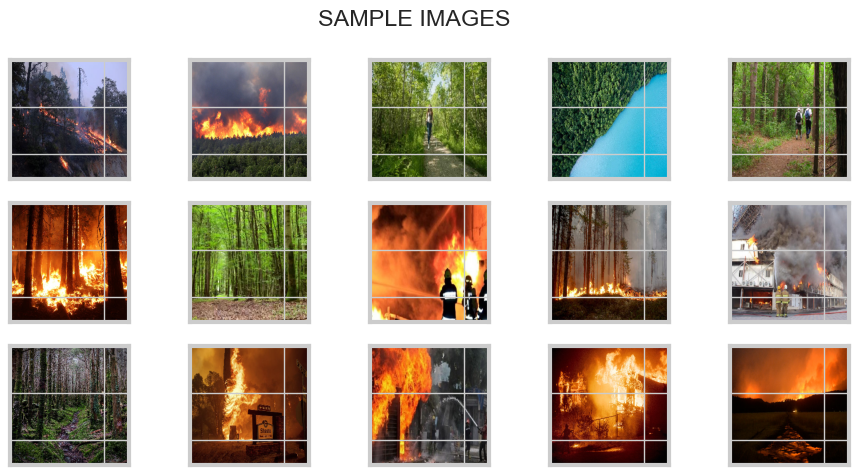

In [25]:
# Menampilkan beberapa gambar contoh dari dataset.
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();


### Menampilkan Gambar yang Diproses

Text(0.5, 1.05, 'SAMPLE PROCESSED IMAGE')

Text(0.5, 1.0, 'ORIG.')

Text(0.5, 1.0, 'MASK')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPEN')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


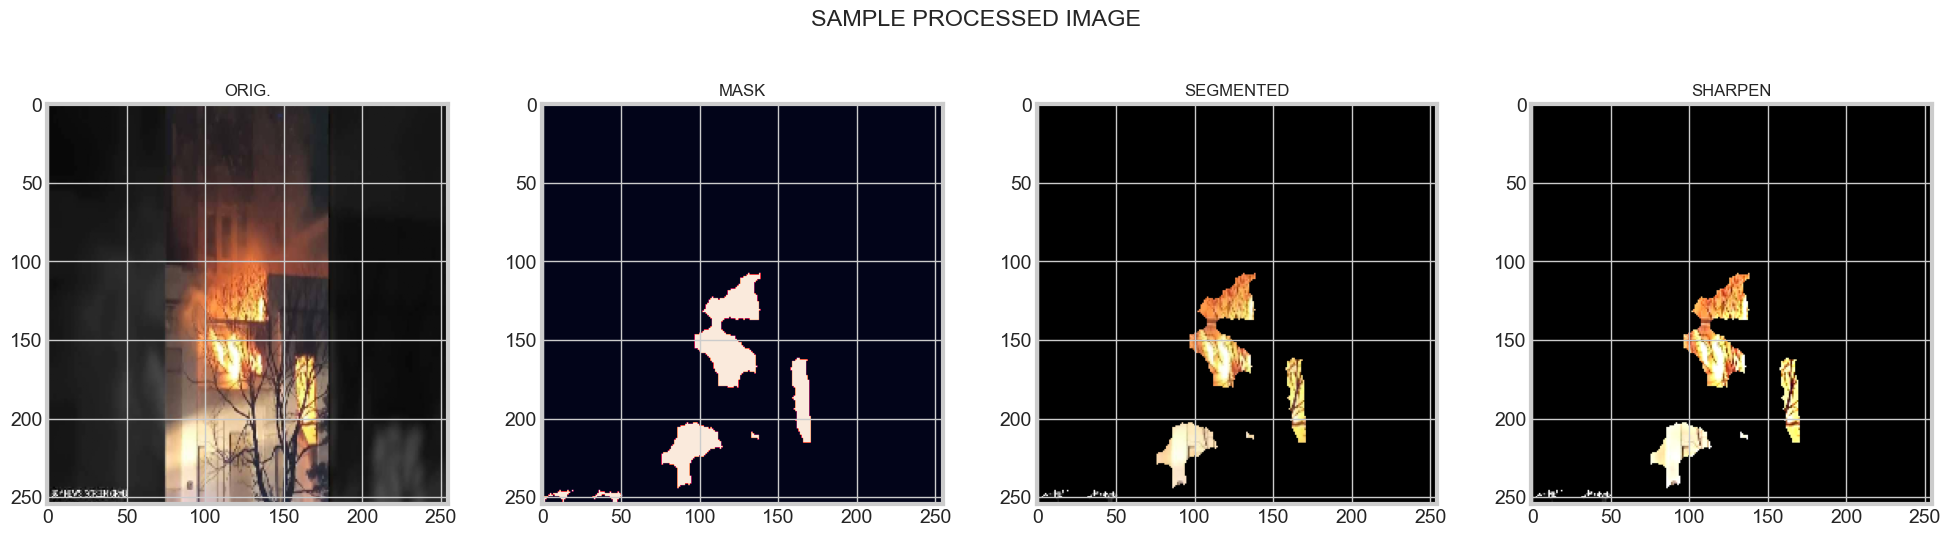

In [26]:
# Mengambil gambar
img = read_img(df['file'][102], (255, 255))
# Membuat mask
image_mask = create_mask_for_plant(img)
# Segmentasi
image_segmented = segment_image(img)
# Menajamkan gambar
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))  # Sesuaikan figsize jika perlu
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=1.05)  # Mengatur judul utama

# Mengatur judul untuk setiap subplot
ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

# Menampilkan gambar pada setiap subplot
ax[0].imshow(img / 255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

plt.tight_layout()  # Memastikan tata letak tidak tumpang tindih
plt.show()


## 4. Proses Learning atau Modelling:

Proses Learning atau Modelling dimulai dengan ekstraksi fitur dari gambar menggunakan model Xception yang telah dilatih sebelumnya. Pertama, gambar diproses melalui masking, segmentasi, dan penajaman, kemudian dipersiapkan untuk input ke model Xception dengan fungsi `xception.preprocess_input`. Setelah itu, data dibagi menjadi set pelatihan dan validasi. Fitur bottleneck diekstraksi menggunakan model Xception yang telah dilatih sebelumnya, menghasilkan fitur yang akan digunakan untuk model klasifikasi. Model deep learning dibangun dengan arsitektur Sequential dari Keras, yang terdiri dari beberapa lapisan Dense dengan aktivasi ReLU dan satu lapisan output dengan aktivasi sigmoid untuk klasifikasi biner. Model ini kemudian dikompilasi menggunakan optimizer Adam dan fungsi loss binary crossentropy, dan siap dilanjutkan untuk training lebih lanjut.

### Ekstraksi Fitur dengan Xception

In [27]:
#Ekstraksi fitur dari gambar menggunakan model Xception yang sudah dilatih sebelumnya.
INPUT_SIZE=255

#preprocess input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #baca gambar
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking dan segmentation
    image_segmented = segment_image(img)
    #sharpen(menajamkan)
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x
    
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

999it [00:33, 29.81it/s]

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


### Split data

In [28]:
#Split data menjadi training dan validation set.
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


### Ekstraksi Fitur Bottleneck

In [29]:
# Ekstraksi fitur dilakukan menggunakan model Xception yang telah dilatih sebelumnya. 
# Gambar yang telah diproses (disegmentasi dan ditajamkan) diubah menjadi fitur bottleneck yang kemudian digunakan sebagai input untuk model klasifikasi.

#Menggunakan Model Xception Pre-trained untuk Ekstraksi Fitur
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')

#Menghasilkan Bottleneck Features
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [30]:
#print bentuk feature dan ukuran
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


### Model Deep Learning

In [31]:
# Model klasifikasi dibuat menggunakan arsitektur Sequential dari Keras. 
# Model ini terdiri dari beberapa lapisan Dense dengan aktivasi ReLU dan satu lapisan output dengan aktivasi sigmoid untuk klasifikasi biner.

# Membangun Model Deep Learning
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,057 (2.06 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Uji Performa Model

Pada tahap uji performa model, pertama-tama model dilatih selama 100 epoch dengan batch size 32. Selama pelatihan, akurasi model meningkat secara signifikan dari 76.63% pada epoch pertama menjadi 93.78% pada epoch terakhir, sementara loss berkurang dari 0.5635 menjadi 0.1254. Setelah pelatihan, model dievaluasi menggunakan data validasi untuk menghitung metrik seperti precision, recall, dan F1-score. Hasil evaluasi menunjukkan akurasi keseluruhan model sebesar 88%, dengan precision dan recall yang tinggi untuk klasifikasi "Fire" (0) dan "Non-Fire" (1). Precision untuk "Fire" adalah 0.98, sedangkan recall untuk "Non-Fire" adalah 0.95. Confusion matrix menunjukkan bahwa model memiliki performa yang baik, dengan True Positives (120), False Positives (22), True Negatives (52), dan False Negatives (3). Grafik loss dan akurasi selama pelatihan juga ditampilkan untuk menunjukkan perkembangan performa model.

### Pelatihan Model

In [32]:
#Model dilatih selama 100 epoch dengan batch size 32
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7663 - loss: 0.5635
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7633 - loss: 0.4749
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7536 - loss: 0.4459
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3727
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8535 - loss: 0.3326
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8333 - loss: 0.3381
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8484 - loss: 0.3234
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8409 - loss: 0.3211
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8416 - loss: 0.3538
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8501 - loss: 0.3136
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8935 - loss: 0.2598
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

### Evaluasi Model

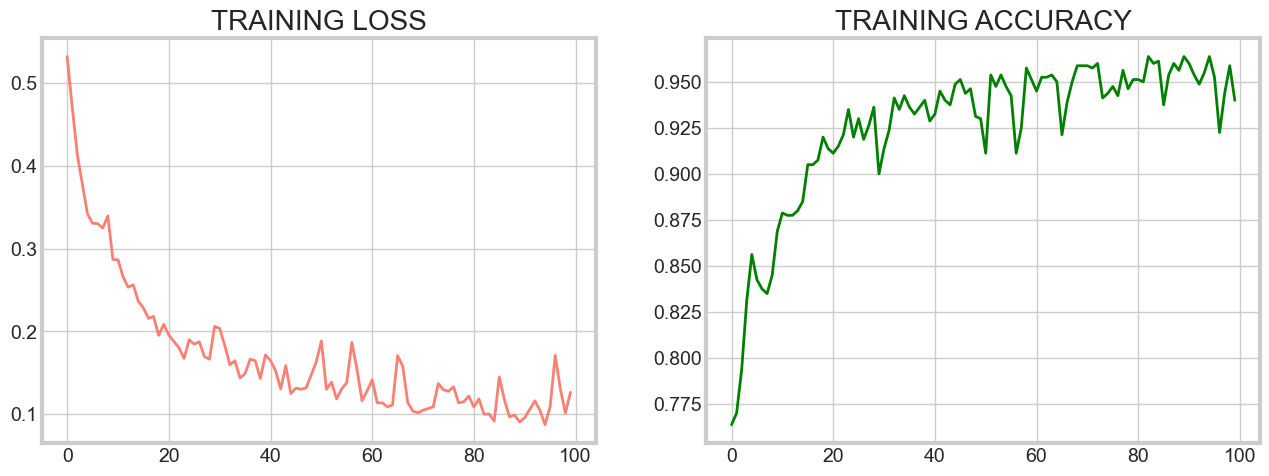

In [33]:
# Model dievaluasi menggunakan data validasi untuk menghitung akurasi dan membuat confusion matrix serta classification report. 
# Hasil evaluasi menunjukkan kinerja model dalam mengklasifikasikan gambar sebagai kebakaran atau non-kebakaran.

# Menampilkan grafik loss dan akurasi selama pelatihan.
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [34]:
# Prediksi probabilitas untuk data validasi
predictions_prob = model.predict(bf_train_val)

# Ubah probabilitas menjadi kelas (0 atau 1)
# Asumsi threshold 0.5 untuk klasifikasi biner
predictions = (predictions_prob > 0.5).astype(int).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [35]:
# Menghitung laporan klasifikasi 

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       145
           1       0.70      0.95      0.81        55

    accuracy                           0.88       200
   macro avg       0.84      0.90      0.86       200
weighted avg       0.90      0.88      0.88       200



#### Hasil Evaluasi Precision, Recall, F1-Score, dan Support:

1. **Precision**:
    - **Kelas "Fire" (0)**: Precision sangat tinggi (0.98), menunjukkan bahwa dari semua prediksi "Fire", 98% benar-benar "Fire".
    - **Kelas "Non-Fire" (1)**: Precision lebih rendah (0.70), menunjukkan bahwa dari semua prediksi "Non-Fire", 70% benar-benar "Non-Fire".

2. **Recall**:
    - **Kelas "Fire" (0)**: Recall adalah 0.85, menunjukkan bahwa dari semua sampel sebenarnya "Fire", 85% berhasil dideteksi dengan benar.
    - **Kelas "Non-Fire" (1)**: Recall sangat tinggi (0.95), menunjukkan bahwa dari semua sampel sebenarnya "Non-Fire", 95% berhasil dideteksi dengan benar.

3. **F1-Score**:
    - **Kelas "Fire" (0)**: F1-Score adalah 0.91, menggabungkan precision dan recall yang tinggi.
    - **Kelas "Non-Fire" (1)**: F1-Score adalah 0.81, menunjukkan keseimbangan antara precision dan recall yang cukup baik.
    
4. **Akurasi**:
    - Akurasi keseluruhan dari model adalah 88%, yang menunjukkan performa yang cukup baik dalam mengklasifikasikan gambar sebagai "Fire" atau "Non-Fire".

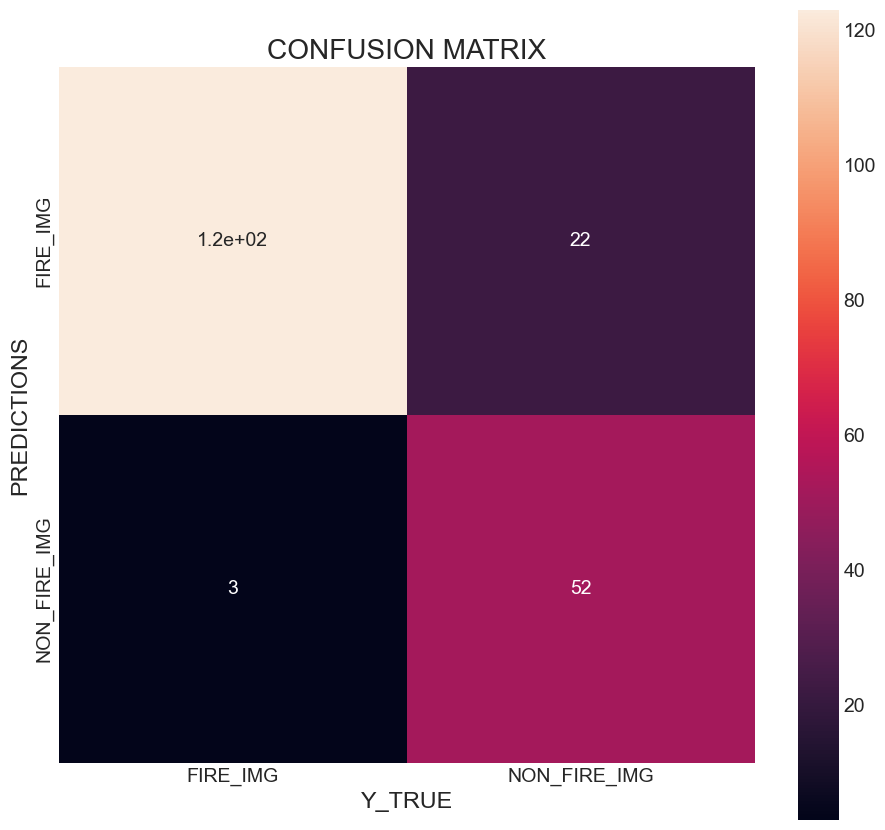

In [36]:
# Menghitung CONFUSION MATRIX

confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

#### Hasil Evaluasi Confusion Matrix:

- **True Positives (TP)**: 120 (Gambar "Fire" yang berhasil diklasifikasikan sebagai "Fire")
- **False Positives (FP)**: 22 (Gambar "Non-Fire" yang salah diklasifikasikan sebagai "Fire")
- **True Negatives (TN)**: 52 (Gambar "Non-Fire" yang berhasil diklasifikasikan sebagai "Non-Fire")
- **False Negatives (FN)**: 3 (Gambar "Fire" yang salah diklasifikasikan sebagai "Non-Fire")

    Confusion matrix menunjukkan bahwa model memiliki performa yang cukup baik dalam mengklasifikasikan gambar sebagai "Fire" atau "Non-Fire".
    


## 6. Kesimpulan

Model deteksi kebakaran berhasil mencapai tujuan utama project, yaitu menciptakan solusi praktis dan efektif untuk deteksi dini kebakaran dengan akurasi tinggi. Hasil pengujian menunjukkan bahwa model ini sangat andal dalam mengidentifikasi kejadian kebakaran. Dengan tingkat true positives yang tinggi, yaitu 120 dari 123 gambar "Fire" yang sebenarnya, dan precision untuk kelas "Fire" yang mencapai 0.98, model ini menunjukkan bahwa 98% dari semua prediksi "Fire" benar-benar merupakan gambar kebakaran. Recall untuk kelas "Fire" adalah 0.85, yang berarti model ini mampu mendeteksi 85% dari semua kejadian kebakaran yang sebenarnya.

Namun, model ini menghasilkan beberapa false positives dengan 22 gambar "Non-Fire" yang salah diklasifikasikan sebagai "Fire", menunjukkan adanya potensi alarm palsu. Precision untuk kelas "Non-Fire" lebih rendah pada 0.70, menunjukkan bahwa hanya 70% dari prediksi "Non-Fire" yang benar-benar bukan kebakaran. Meski demikian, recall untuk kelas "Non-Fire" sangat tinggi pada 0.95, menunjukkan bahwa model ini sangat efektif dalam mendeteksi gambar "Non-Fire" dengan akurasi 95%.

F1-Score untuk kelas "Fire" adalah 0.91, menggabungkan precision dan recall yang tinggi, menunjukkan keseimbangan yang baik dalam mendeteksi gambar kebakaran. F1-Score untuk kelas "Non-Fire" adalah 0.81, menunjukkan keseimbangan yang cukup baik antara precision dan recall, meskipun masih ada ruang untuk perbaikan. Akurasi keseluruhan model adalah 88%, menunjukkan performa yang cukup baik dalam mengklasifikasikan gambar sebagai "Fire" atau "Non-Fire".